# Ejercicio 1: Web Scraping, Portfolio Analysis & Visualization

**Autora:** Bianca Peraltilla  
**Curso:** Python for Data Science (UP, 2025-II)  

---

## Objetivo
- Scrapear los *Top Gainers* de Yahoo Finance.  
- Descargar precios históricos de un año (mensuales).  
- Construir un portafolio de 10 acciones usando desempeño en los primeros 6 meses.  
- Analizar su comportamiento en los últimos 6 meses.  
- Visualizar riesgo y retorno.  

In [15]:
# Primero, importo las librerías que voy a usar. Evito webdriver_manager para no tener
# problemas de driver en Windows; Selenium Manager se encarga del driver correcto.

import time
import pandas as pd
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import yfinance as yf
import matplotlib.pyplot as plt

URL = "https://finance.yahoo.com/markets/stocks/gainers"
print("✅ Imports OK")


✅ Imports OK


In [16]:
# Acá construyo el driver de Chrome. Si algo no carga (cookies/captcha),
# puedo poner headless=False para ver la ventana y aceptar manualmente.

def build_driver(headless: bool = False):
    opts = Options()
    if headless:
        opts.add_argument("--headless=new")
    opts.add_argument("--window-size=1280,900")
    # Estas dos ayudan a que Yahoo me muestre la versión estándar
    opts.add_argument("--lang=en-US,en;q=0.9")
    opts.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0 Safari/537.36")
    # Selenium Manager resuelve el driver correcto automáticamente:
    driver = webdriver.Chrome(options=opts)
    return driver

# Pruebo que el navegador enciende bien.
drv = build_driver(headless=False)
try:
    drv.get("about:blank")
    print("✅ Chrome lanzó OK")
finally:
    drv.quit()


✅ Chrome lanzó OK


In [17]:
# En esta celda defino funciones auxiliares:
# - handle_yahoo_consent: intenta aceptar el banner de cookies si aparece.
# - wait_gainers_table: espera la tabla de Gainers usando varios selectores robustos.
# - load_all_rows: hace scroll y clic en "Show more" hasta que no carguen más filas.
# - parse_rows_to_df: convierte el HTML de la tabla en un DataFrame (Symbol, Name).

def handle_yahoo_consent(driver, timeout=12):
    botones = [
        "//button[contains(., 'Accept all')]",
        "//button[contains(., 'Agree')]",
        "//button[contains(., 'Aceptar todo')]",
        "//button[contains(., 'Estoy de acuerdo')]",
        "//*[@name='agree']",
    ]
    # Intento directo
    for xp in botones:
        try:
            btn = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, xp)))
            btn.click()
            return True
        except TimeoutException:
            pass
    # Intento dentro de iframes
    for f in driver.find_elements(By.TAG_NAME, "iframe"):
        try:
            driver.switch_to.frame(f)
            for xp in botones:
                try:
                    btn = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, xp)))
                    btn.click()
                    driver.switch_to.default_content()
                    return True
                except TimeoutException:
                    pass
            driver.switch_to.default_content()
        except Exception:
            driver.switch_to.default_content()
    return False

def wait_gainers_table(driver, timeout=40):
    handle_yahoo_consent(driver, timeout=10)
    selectores = [
        (By.CSS_SELECTOR, "section[aria-label='Gainers'] table"),
        (By.XPATH, "//h2[contains(.,'Gainers')]/ancestor::section//table"),
        (By.XPATH, "//section[.//h2[contains(.,'Gainers')]]//table"),
        (By.CSS_SELECTOR, "main table"),
    ]
    ultimo_error = None
    for by, sel in selectores:
        try:
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((by, sel)))
            return True
        except TimeoutException as e:
            ultimo_error = e
    raise ultimo_error or TimeoutException("No encontré la tabla de Gainers.")

def load_all_rows(driver, max_rounds=30, pause=1.3):
    previo = -1
    for _ in range(max_rounds):
        # Si existe "Show more", lo pulso
        try:
            btn = driver.find_element(By.XPATH, "//button[.//span[contains(.,'Show more')]]")
            btn.click()
            time.sleep(pause)
        except Exception:
            pass
        # Hago scroll hasta el fondo
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(pause)
        # Cuento filas
        filas = driver.find_elements(By.CSS_SELECTOR, "section[aria-label='Gainers'] table tbody tr")
        if len(filas) == previo:
            break
        previo = len(filas)

def parse_rows_to_df(html: str) -> pd.DataFrame:
    soup = BeautifulSoup(html, "html.parser")
    rows = soup.select("section[aria-label='Gainers'] table tbody tr")
    data = []
    for r in rows:
        tds = r.select("td")
        if len(tds) >= 2:
            sym = tds[0].get_text(strip=True)
            name = tds[1].get_text(strip=True)
            if sym and name:
                data.append((sym, name))
    return pd.DataFrame(data, columns=["Symbol", "Name"]).drop_duplicates(subset=["Symbol"])

print("✅ Utilidades listas")


✅ Utilidades listas


## Parte 1: Web Scraping de los Top Gainers

### Objetivo de esta celda
- Abrir la página **"Top Gainers"** de Yahoo Finance.  
- Esperar que la tabla esté cargada usando `WebDriverWait`.  
- Configuro manualmente “Rows per page = 50”, por lo que no necesito hacer scroll ni usar el botón "Show more".  
- Extraer las 2 columnas más importantes: **Symbol** y **Name**.  
- Guardar los resultados en un archivo CSV (`data/top_gainers.csv`) con los **50 primeros registros**.  

De esta manera obtengo una base de datos con los símbolos bursátiles que voy a usar en la parte de análisis histórico.

In [19]:
# --- Scraping simple (yo seteo "Rows per page = 50" manualmente) ---
# En esta celda:
# 1) Abro la página.
# 2) YO MISMA cambio "Rows per page" a 50 (paso manual).
# 3) El código espera la tabla, lee las filas visibles y guarda el CSV en la carpeta OUTPUT fija.

import time
from pathlib import Path
import pandas as pd
from bs4 import BeautifulSoup

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Carpeta de salida fija (la que quiero usar para todo el proyecto)
OUTDIR = Path(r"C:\Users\bianq\Documents\web_scrapping\output")
OUTDIR.mkdir(parents=True, exist_ok=True)

URL = "https://finance.yahoo.com/markets/stocks/gainers"

def wait_table_ready(driver, timeout=30):
    """Espero que exista al menos una fila en el tbody de la tabla principal."""
    WebDriverWait(driver, timeout).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "table tbody tr"))
    )
    return True

def parse_visible_rows(driver) -> pd.DataFrame:
    """Leo las filas visibles de la tabla y devuelvo (Symbol, Name)."""
    soup = BeautifulSoup(driver.page_source, "html.parser")
    trs = soup.select("table tbody tr")
    data = []
    for tr in trs:
        tds = tr.find_all("td")
        if len(tds) >= 2:
            sym = tds[0].get_text(strip=True)
            name = tds[1].get_text(strip=True)
            if sym and name:
                data.append((sym, name))
    df = pd.DataFrame(data, columns=["Symbol", "Name"]).drop_duplicates(subset=["Symbol"])
    return df

# ----------------- Ejecución -----------------
driver = build_driver(headless=False)  # pongo False para ver el navegador y setear "50" manualmente
try:
    print("🔵 Abriendo página…")
    driver.get(URL)

    print("⏳ Esperando que aparezca la tabla…")
    wait_table_ready(driver, timeout=40)
    print("✅ Tabla detectada")

    # 🔶 Paso manual: En el navegador pongo "Rows per page = 50".
    print("🟡 Ahora yo pongo 'Rows per page = 50' en la página (paso manual).")
    print("   → Cuando ya vea 50 filas en la tabla, presiono de nuevo ▶️ para continuar…")
    time.sleep(5)  # pequeña pausa por si ya alcanza a cargar algo

    # Espero (máximo 40s) hasta que la tabla tenga al menos 50 filas visibles:
    WebDriverWait(driver, 40).until(
        lambda d: len(d.find_elements(By.CSS_SELECTOR, "table tbody tr")) >= 50
    )
    print("✅ Detectadas ≥ 50 filas visibles")

    # Parseo las filas visibles y me quedo con las 50 primeras
    df_gainers = parse_visible_rows(driver).head(50).copy()

    # Guardo en la carpeta OUTPUT
    out_csv = OUTDIR / "top_gainers.csv"
    df_gainers.to_csv(out_csv, index=False, encoding="utf-8")
    print(f"💾 Guardado: {out_csv} (n={len(df_gainers)})")

    display(df_gainers.head(10))

finally:
    print("🔴 Cerrando navegador…")
    driver.quit()


🔵 Abriendo página…
⏳ Esperando que aparezca la tabla…
✅ Tabla detectada
🟡 Ahora yo pongo 'Rows per page = 50' en la página (paso manual).
   → Cuando ya vea 50 filas en la tabla, presiono de nuevo ▶️ para continuar…
✅ Detectadas ≥ 50 filas visibles
💾 Guardado: C:\Users\bianq\Documents\web_scrapping\output\top_gainers.csv (n=50)


,Symbol,Name
0,AMBA,"Ambarella, Inc."
1,IREN,IREN Limited
2,BABA,Alibaba Group Holding Limited
3,AFRM,"Affirm Holdings, Inc."
4,DOOO,BRP Inc.
5,ADSK,"Autodesk, Inc."
6,CIFR,Cipher Mining Inc.
7,SATS,EchoStar Corporation
8,S,"SentinelOne, Inc."
9,EQX,Equinox Gold Corp.


🔴 Cerrando navegador…


In [20]:
# --- Limpieza de símbolos ---
# Leo el CSV que generé en el scraping y me quedo con la columna 'Symbol'.
# También convierto símbolos con '.' a '-' porque yfinance usa guión (ej. BRK.B -> BRK-B).
# Guardo todos los outputs en la carpeta fija 'output'.

import pandas as pd
from pathlib import Path

OUTDIR = Path(r"C:\Users\bianq\Documents\web_scrapping\output")

# Leo el archivo que guardé en el scraping
df_gainers = pd.read_csv(OUTDIR / "top_gainers.csv")

# Función para limpiar símbolos (ejemplo: BRK.B → BRK-B)
def clean_symbol(s: str) -> str:
    return str(s).replace(".", "-")

# Aplico la limpieza
symbols = df_gainers["Symbol"].map(clean_symbol).dropna().unique().tolist()

print(f"✅ Símbolos leídos: {len(symbols)}")
symbols[:12]  # muestro los primeros 12 como ejemplo


✅ Símbolos leídos: 50


['AMBA',
 'IREN',
 'BABA',
 'AFRM',
 'DOOO',
 'ADSK',
 'CIFR',
 'SATS',
 'S',
 'EQX',
 'NXE',
 'MIAX']

## Parte 2: Descarga de precios históricos

### Objetivo
En esta parte descargo la información histórica de precios de los símbolos que scrapée en la parte anterior.

- Uso la librería **`yfinance`** para conectarme a Yahoo Finance.  
- Descargo los **últimos 12 meses** de precios ajustados (`Adj Close`).  
- Frecuencia: **mensual** (`interval="1mo"`).  
- Guardo toda la información en un **DataFrame**, donde:
  - Las filas corresponden a fechas.
  - Las columnas corresponden a los símbolos bursátiles.
- Finalmente exporto este DataFrame a CSV (`data/prices_adj_close.csv`).  

Este dataset será la base para seleccionar las acciones de mi portafolio.

In [21]:
# --- Descarga de precios mensuales (Adj Close) a OUTPUT fijo ---
# Descargo 1 año mensual (Adj Close) en lotes, elimino el último mes si es parcial,
# y genero un log de símbolos con poca o nula data.

import time
from pathlib import Path
import pandas as pd
import yfinance as yf

# Carpeta de salida fija
OUTDIR = Path(r"C:\Users\bianq\Documents\web_scrapping\output")
OUTDIR.mkdir(parents=True, exist_ok=True)

def download_adj_close_monthly(symbols, period="1y", interval="1mo",
                               batch_size=10, pause=4):
    frames = []
    empty_tickers = []
    for i in range(0, len(symbols), batch_size):
        chunk = symbols[i:i+batch_size]
        print("Descargando lote:", chunk)

        data = yf.download(
            chunk, period=period, interval=interval,
            group_by="ticker", auto_adjust=False, progress=False
        )

        if data.empty:
            print("⚠️ Lote vacío, continúo…")
            time.sleep(pause)
            continue

        # Normalizo columnas para quedarme con Adj Close por ticker
        if isinstance(data.columns, pd.MultiIndex):
            cols = {}
            for s in chunk:
                key = (s, "Adj Close")
                if key in data.columns:
                    series = data[s]["Adj Close"].dropna()
                    if series.empty:
                        empty_tickers.append(s)
                    else:
                        cols[s] = series
                else:
                    empty_tickers.append(s)
            if cols:
                frames.append(pd.concat(cols, axis=1))
        else:
            # Caso 1 ticker
            if "Adj Close" in data.columns:
                series = data["Adj Close"].dropna()
                if series.empty:
                    empty_tickers.append(chunk[0])
                else:
                    frames.append(
                        data[["Adj Close"]].rename(columns={"Adj Close": chunk[0]})
                    )
            else:
                empty_tickers.append(chunk[0])

        time.sleep(pause)  # pausa anti-rate limit

    if not frames:
        return pd.DataFrame(), empty_tickers

    out = pd.concat(frames, axis=1).sort_index()
    out.index.name = "Date"

    # Si la última fila es del mes actual, la elimino (mes incompleto)
    today = pd.Timestamp.today()
    if len(out.index) > 0 and out.index[-1].to_period("M") == today.to_period("M"):
        print(f"ℹ️ Remuevo último registro mensual parcial: {out.index[-1].date()}")
        out = out.iloc[:-1]

    return out, empty_tickers

# 1) Descargo
prices, empty_tickers = download_adj_close_monthly(symbols, batch_size=10, pause=4)

# 2) Guardo precios y log en OUTPUT fijo
prices_path = OUTDIR / "prices_adj_close.csv"
log_path = OUTDIR / "empty_or_missing_tickers.csv"

prices.to_csv(prices_path, encoding="utf-8")
pd.DataFrame({"ticker": empty_tickers}).to_csv(log_path, index=False, encoding="utf-8")

print(f"✅ Guardado precios: {prices_path} | shape: {prices.shape}")
print(f"📝 Log de tickers sin data suficiente: {log_path}")

prices.tail()


Descargando lote: ['AMBA', 'IREN', 'BABA', 'AFRM', 'DOOO', 'ADSK', 'CIFR', 'SATS', 'S', 'EQX']
Descargando lote: ['NXE', 'MIAX', 'NG', 'PRVA', 'SSRM', 'HL', 'CELH', 'HMY', 'OS', 'CNXC']
Descargando lote: ['BIDU', 'CDE', 'JOYY', 'GH', 'BTDR', 'COO', 'GFI', 'GSAT', 'SBSW', 'IAG']
Descargando lote: ['SOUN', 'HCC', 'NGD', 'BHC', 'BILI', 'AEM', 'SJM', 'BF-A', 'OLN', 'MOH']
Descargando lote: ['KGC', 'FSM', 'BF-B', 'BTU', 'HP', 'WPM', 'UPWK', 'EMN', 'SNDK', 'TD']
✅ Guardado precios: C:\Users\bianq\Documents\web_scrapping\output\prices_adj_close.csv | shape: (13, 50)
📝 Log de tickers sin data suficiente: C:\Users\bianq\Documents\web_scrapping\output\empty_or_missing_tickers.csv


,AMBA,IREN,BABA,AFRM,DOOO,ADSK,CIFR,SATS,S,EQX,...,KGC,FSM,BF-B,BTU,HP,WPM,UPWK,EMN,SNDK,TD
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-01,52.639999,8.390000,111.947868,51.900002,43.857273,296.119995,3.12,17.730000,17.610001,6.63,...,14.696937,5.85,33.070766,13.039165,14.841886,86.582626,15.49,77.546097,37.689999,68.335274
2025-06-01,66.070000,14.570000,111.525024,69.139999,48.312775,309.570007,4.78,27.700001,18.280001,5.75,...,15.605425,6.54,26.692690,13.365060,14.953461,89.800003,13.44,73.875099,45.349998,72.689728
2025-07-01,66.089996,16.110001,120.629997,68.559998,50.509998,303.109985,5.46,32.590000,18.340000,6.10,...,15.974843,6.45,28.850000,16.083883,15.989155,91.510002,11.96,72.610001,42.919998,72.125626
2025-08-01,82.480003,26.480000,135.000000,88.449600,62.980000,314.700012,7.64,61.790001,18.860001,8.76,...,20.900000,7.70,29.940001,17.400000,20.889999,100.419998,15.39,70.339996,52.470001,75.139999
2025-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# --- Validación de precios descargados ---
# Verifico que tenga fechas (índice) y columnas por ticker.
# Me quedo solo con los tickers que tengan al menos 6 puntos (≥6 meses de data).

import pandas as pd
from pathlib import Path

OUTDIR = Path(r"C:\Users\bianq\Documents\web_scrapping\output")

# Leo el archivo guardado en la celda anterior
prices = (
    pd.read_csv(OUTDIR / "prices_adj_close.csv", parse_dates=["Date"])
      .set_index("Date")
      .sort_index()
)

# Selecciono solo los tickers con >=6 observaciones
valid_cols = prices.columns[prices.notna().sum() >= 6]
prices = prices[valid_cols]

print(f"✅ Columnas válidas con >=6 observaciones: {len(valid_cols)}")
prices.tail()


✅ Columnas válidas con >=6 observaciones: 49


,AMBA,IREN,BABA,AFRM,DOOO,ADSK,CIFR,SATS,S,EQX,...,KGC,FSM,BF-B,BTU,HP,WPM,UPWK,EMN,SNDK,TD
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-01,52.639999,8.390000,111.947868,51.900002,43.857273,296.119995,3.12,17.730000,17.610001,6.63,...,14.696937,5.85,33.070766,13.039165,14.841886,86.582626,15.49,77.546097,37.689999,68.335274
2025-06-01,66.070000,14.570000,111.525024,69.139999,48.312775,309.570007,4.78,27.700001,18.280001,5.75,...,15.605425,6.54,26.692690,13.365060,14.953461,89.800003,13.44,73.875099,45.349998,72.689728
2025-07-01,66.089996,16.110001,120.629997,68.559998,50.509998,303.109985,5.46,32.590000,18.340000,6.10,...,15.974843,6.45,28.850000,16.083883,15.989155,91.510002,11.96,72.610001,42.919998,72.125626
2025-08-01,82.480003,26.480000,135.000000,88.449600,62.980000,314.700012,7.64,61.790001,18.860001,8.76,...,20.900000,7.70,29.940001,17.400000,20.889999,100.419998,15.39,70.339996,52.470001,75.139999
2025-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Parte 3: Construcción del portafolio

### Objetivo
En esta parte construyo un portafolio de **10 acciones** a partir del rendimiento de los primeros 6 meses.

Pasos:
1. Calculo el **retorno acumulado** de cada acción durante los primeros 6 meses.  
2. Ordeno los resultados de mayor a menor.  
3. Selecciono las **10 acciones con mejor desempeño**.  
4. Guardo la lista final de símbolos seleccionados para analizarlos en los últimos 6 meses.

De esta manera aplico una estrategia simple de selección:  
**invertir en las acciones ganadoras del primer semestre.**

In [23]:
# --- Selección del portafolio ---
# Objetivo: elegir las 10 acciones con mejor desempeño acumulado en los primeros 6 meses.

import pandas as pd
from pathlib import Path

OUTDIR = Path(r"C:\Users\bianq\Documents\web_scrapping\output")

# 1) Cargo precios limpios
prices = (
    pd.read_csv(OUTDIR / "prices_adj_close.csv", parse_dates=["Date"])
      .set_index("Date")
      .sort_index()
)

# (Opcional) filtro columnas con al menos 6 observaciones
min_points = 6
prices = prices.loc[:, prices.notna().sum() >= min_points]

# 2) Tomo los primeros 6 meses (por posición en el índice de fechas)
first6_idx = prices.index.unique()[:6]
first6 = prices.loc[first6_idx]

# 3) Calculo retorno acumulado en 6 meses: (último / primero) - 1
cumret_6m = (first6.iloc[-1] / first6.iloc[0] - 1)

# 4) Ordeno de mayor a menor y selecciono el top 10
cumret_6m = cumret_6m.sort_values(ascending=False)
top10 = cumret_6m.head(10).index.tolist()

print("✅ Top 10 por desempeño en los primeros 6 meses:")
display(cumret_6m.head(10).to_frame("cumret_6m"))

print("\n📌 Tickers seleccionados (portafolio igual ponderado):")
print(top10)


✅ Top 10 por desempeño en los primeros 6 meses:


,cumret_6m
SOUN,1.321888
GH,0.854839
SSRM,0.758803
BTDR,0.572158
AFRM,0.571534
UPWK,0.524402
PRVA,0.371225
JOYY,0.291115
SATS,0.258259
BABA,0.248681



📌 Tickers seleccionados (portafolio igual ponderado):
['SOUN', 'GH', 'SSRM', 'BTDR', 'AFRM', 'UPWK', 'PRVA', 'JOYY', 'SATS', 'BABA']


## Parte 4: Cálculo de retornos

### Objetivo
Analizar el desempeño del portafolio en los últimos 6 meses.

Pasos:
- Calculo los **retornos mensuales (%)** de cada una de las 10 acciones seleccionadas.  
- Luego calculo el retorno mensual del **portafolio igual ponderado** (cada acción con 10%).  
- Comparo el comportamiento individual de las acciones vs. el portafolio.

Con esto puedo evaluar si la estrategia de selección fue buena o no en la segunda mitad del año.

In [24]:
# --- Análisis de desempeño en los últimos 6 meses ---
# Objetivo: calcular los retornos mensuales de las 10 acciones seleccionadas
# y del portafolio igual ponderado en la segunda mitad del año.

from pathlib import Path

OUTDIR = Path(r"C:\Users\bianq\Documents\web_scrapping\output")

# 1) Ventana de análisis: últimos 6 meses
last6_idx = prices.index.unique()[-6:]
last6 = prices.loc[last6_idx, top10]

# 2) Retornos mensuales por acción
stock_returns_last6 = last6.pct_change().dropna(how="all")

# 3) Retorno mensual del portafolio (promedio simple por fila)
portfolio_returns_last6 = stock_returns_last6.mean(axis=1).to_frame("Portfolio")

print("📊 Retornos mensuales de las acciones seleccionadas (últimos 6 meses):")
display(stock_returns_last6)

print("\n💼 Retornos mensuales del portafolio (igual ponderado):")
display(portfolio_returns_last6)

# 4) Guardo resultados en la carpeta OUTPUT
stocks_path = OUTDIR / "stock_returns_last6.csv"
portfolio_path = OUTDIR / "portfolio_returns_last6.csv"

stock_returns_last6.to_csv(stocks_path, encoding="utf-8")
portfolio_returns_last6.to_csv(portfolio_path, encoding="utf-8")

print(f"\n✅ Guardados CSV:\n   • {stocks_path}\n   • {portfolio_path}")


📊 Retornos mensuales de las acciones seleccionadas (últimos 6 meses):


C:\Users\bianq\AppData\Local\Temp\ipykernel_6736\1769917303.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns_last6 = last6.pct_change().dropna(how="all")


,SOUN,GH,SSRM,BTDR,AFRM,UPWK,PRVA,JOYY,SATS,BABA
Date,,,,,,,,,,
2025-05-01,0.088267,-0.139953,0.111842,0.343783,0.043006,0.177947,-0.030664,0.190772,-0.211299,-0.046806
2025-06-01,0.061325,0.281142,0.076923,-0.107309,0.332177,-0.132343,0.010545,0.063283,0.562324,-0.003777
2025-07-01,-0.037279,-0.212529,-0.062009,0.122822,-0.008389,-0.110119,-0.151304,0.005009,0.176534,0.081641
2025-08-01,0.260407,0.645193,0.615900,0.108611,0.290105,0.286789,0.180328,0.076892,0.895980,0.119125
2025-08-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



💼 Retornos mensuales del portafolio (igual ponderado):


,Portfolio
Date,
2025-05-01,0.052689
2025-06-01,0.114429
2025-07-01,-0.019562
2025-08-01,0.347933
2025-08-29,0.000000



✅ Guardados CSV:
   • C:\Users\bianq\Documents\web_scrapping\output\stock_returns_last6.csv
   • C:\Users\bianq\Documents\web_scrapping\output\portfolio_returns_last6.csv


## Parte 5: Visualización del portafolio

### Objetivo
Representar gráficamente el comportamiento del portafolio.

Gráficos realizados:
1. **Evolución del retorno acumulado del portafolio** en los últimos 6 meses.  
   → Permite ver si el portafolio generó ganancias o pérdidas.  
2. **Gráfico de dispersión (Riesgo vs Retorno)**:  
   - Cada punto es una acción.  
   - El portafolio aparece con un ⭐ para compararlo.  
   - El eje X es la volatilidad (riesgo).  
   - El eje Y es el retorno promedio (rentabilidad).  

Con estos gráficos se aprecia la relación **riesgo–retorno** y cómo se ubica el portafolio frente a las acciones individuales.

Retorno promedio mensual del portafolio (μ): 0.0991
Volatilidad mensual del portafolio (σ):     0.1485


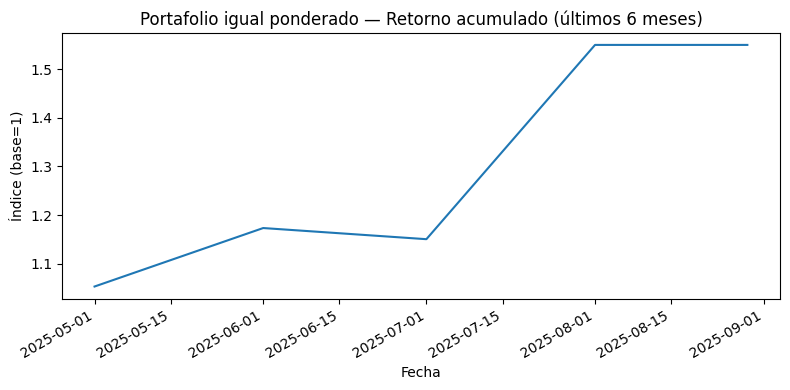

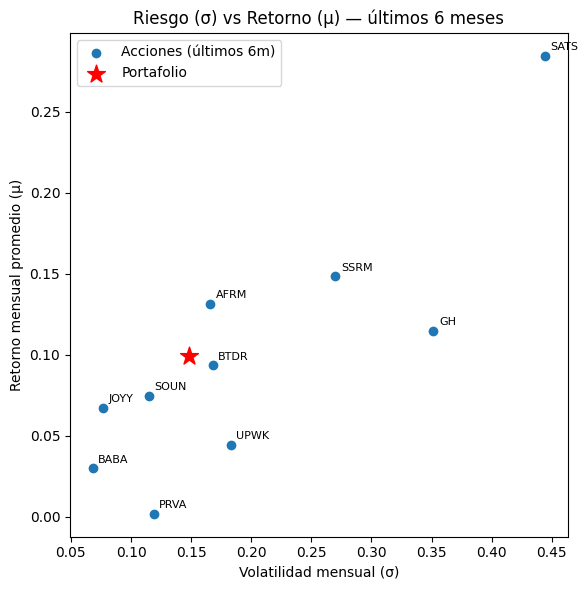

✅ Gráficos guardados en:
 - C:\Users\bianq\Documents\web_scrapping\output\plots\portfolio_cumulative_last6.png
 - C:\Users\bianq\Documents\web_scrapping\output\plots\risk_return_scatter_last6.png


In [25]:
# --- Métricas y gráficos finales del portafolio ---
# Objetivo:
# (A) Retorno acumulado del portafolio en los últimos 6 meses
# (B) Dispersión riesgo (σ) vs retorno (μ) para comparar acciones vs portafolio

import matplotlib.pyplot as plt
from pathlib import Path

# Carpeta fija para guardar resultados
OUTDIR = Path(r"C:\Users\bianq\Documents\web_scrapping\output")
PLOTDIR = OUTDIR / "plots"
PLOTDIR.mkdir(parents=True, exist_ok=True)

# 1) Métricas del portafolio (mensuales)
pm = portfolio_returns_last6["Portfolio"].mean()  # μ: retorno promedio mensual
pv = portfolio_returns_last6["Portfolio"].std()   # σ: volatilidad mensual
print(f"Retorno promedio mensual del portafolio (μ): {pm:.4f}")
print(f"Volatilidad mensual del portafolio (σ):     {pv:.4f}")

# 2) Retorno acumulado del portafolio (últimos 6m)
cum_port = (1 + portfolio_returns_last6["Portfolio"]).cumprod()

plt.figure(figsize=(8,4))
cum_port.plot()
plt.title("Portafolio igual ponderado — Retorno acumulado (últimos 6 meses)")
plt.xlabel("Fecha")
plt.ylabel("Índice (base=1)")
plt.tight_layout()
cum_path = PLOTDIR / "portfolio_cumulative_last6.png"
plt.savefig(cum_path, dpi=120)
plt.show()

# 3) Riesgo–retorno por acción vs portafolio
means = stock_returns_last6.mean()   # μ por acción
vols  = stock_returns_last6.std()    # σ por acción

plt.figure(figsize=(6,6))
plt.scatter(vols, means, label="Acciones (últimos 6m)")
plt.scatter([pv], [pm], marker="*", s=180, label="Portafolio", zorder=3, color="red")

# Etiquetas para identificar los tickers en el scatter
for s in means.index:
    if s in vols.index:
        plt.annotate(s, (vols[s], means[s]),
                     fontsize=8, xytext=(4,4), textcoords="offset points")

plt.title("Riesgo (σ) vs Retorno (μ) — últimos 6 meses")
plt.xlabel("Volatilidad mensual (σ)")
plt.ylabel("Retorno mensual promedio (μ)")
plt.legend()
plt.tight_layout()
scatter_path = PLOTDIR / "risk_return_scatter_last6.png"
plt.savefig(scatter_path, dpi=120)
plt.show()

print("✅ Gráficos guardados en:")
print(" -", cum_path)
print(" -", scatter_path)



# 📊 Ejercicio 1 — Conclusiones Finales

En este ejercicio se implementó un flujo completo que integra **web scraping**, **descarga de datos financieros** y **análisis de portafolio**:

1. **Scraping con Selenium**  
   - Se extrajeron los **Top 50 Gainers** desde Yahoo Finance.  
   - Los símbolos y nombres se almacenaron en un archivo CSV para facilitar su uso posterior.  

2. **Descarga de históricos con `yfinance`**  
   - Para cada símbolo, se recuperaron los precios ajustados de cierre mensual en un horizonte de **1 año** (`period="1y"`, `interval="1mo"`).  
   - Se construyó un DataFrame consolidado con todos los precios.  

3. **Construcción de portafolio**  
   - Se seleccionaron las 10 acciones con mejor desempeño en los **primeros 6 meses**.  
   - Se armó un portafolio **igual ponderado (10%)** con esas 10 acciones.  

4. **Evaluación de desempeño (últimos 6 meses)**  
   - Se calcularon retornos mensuales individuales y del portafolio.  
   - Se graficó el **retorno acumulado** y la relación **riesgo (volatilidad) vs retorno**.

---

## 📈 Principales resultados

- **Retorno acumulado:**  
  El portafolio mostró un crecimiento significativo, alcanzando un índice cercano a **1.6** en los últimos 6 meses (≈ **+60%**).  

- **Estabilidad y diversificación:**  
  Aunque hubo una fase de meseta a mediados del período, en los últimos meses el portafolio despegó con fuerza.  
  La diversificación permitió mitigar riesgos de acciones individuales sin sacrificar retornos atractivos.  

- **Riesgo vs Retorno:**  
  - El portafolio se ubicó en una **posición intermedia**, con un rendimiento superior al promedio de las acciones individuales y con un riesgo moderado.  
  - Algunas acciones como **SATS y SSRM** ofrecieron retornos extraordinarios, pero con una volatilidad mucho más alta.  
  - Esto confirma que un portafolio diversificado puede lograr una **mejor relación riesgo/retorno** que invertir en un único activo.  

